In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 디렉토리와 jpeg 파일명을 읽어서 파일의 절대경로 위치와 학습/테스트 데이터 셋 여부, 해당 이미지의 label 값을 설정 

In [3]:
paths = []
dataset_gubuns = []
label_gubuns = []
# os.walk()를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리를 모두 조사. 
# cat-and-dog 하위 디렉토리 밑에 jpg 확장자를 가진 파일이 모두 이미지 파일임
# cat-and-dog 밑으로 /train/, /test/ 하위 디렉토리 존재(학습, 테스트 용 이미지 파일들을 가짐)

for dirname, _, filenames in tqdm(os.walk('/content/drive/MyDrive/New_Colab/CNN/CatandDog')):
    for filename in filenames:
        # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
        if '.jpg' in filename:
            # 파일의 절대 경로를 file_path 변수에 할당. 
            file_path = dirname+'/'+ filename
            paths.append(file_path)
            # 파일의 절대 경로에 training_set, test_set가 포함되어 있으면 데이터 세트 구분을 'train'과 'test'로 분류. 
            if '/training_set/' in file_path:
                dataset_gubuns.append('train')  
            elif '/test_set/' in file_path:
                dataset_gubuns.append('test')
            else: dataset_gubuns.append('N/A')
            
            # 파일의 절대 경로에 dogs가 있을 경우 해당 파일은 dog 이미지 파일이고, cats일 경우는 cat 이미지 파일임. 
            if 'dogs' in file_path:
                label_gubuns.append('DOG')
            elif 'cats' in file_path:
                label_gubuns.append('CAT')
            else: label_gubuns.append('N/A')

9it [00:35,  3.92s/it]


In [ ]:
paths[:10] , dataset_gubuns[:10], label_gubuns[:10]

(['/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4115.jpg',
  '/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4043.jpg',
  '/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4098.jpg',
  '/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4120.jpg',
  '/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4073.jpg',
  '/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4041.jpg',
  '/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4060.jpg',
  '/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4106.jpg',
  '/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4108.jpg',
  '/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4076.jpg'],
 ['test',
  'test',
  'test',
  'test',
  'test',
  'test',
  'test',
  'test',

### 위에서 생성된 이미지 파일의 절대 경로, 데이터 세트 구분, Lable값을 DataFrame으로 생성. 

In [ ]:
pd.set_option('display.max_colwidth', 200)

data_df = pd.DataFrame({'path':paths, 'dataset':dataset_gubuns, 'label':label_gubuns})
print('data_df shape:', data_df.shape)
data_df.head(10)

data_df shape: (10028, 3)


,path,dataset,label
0,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4115.jpg,test,DOG
1,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4043.jpg,test,DOG
2,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4098.jpg,test,DOG
3,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4120.jpg,test,DOG
4,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4073.jpg,test,DOG
5,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4041.jpg,test,DOG
6,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4060.jpg,test,DOG
7,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4106.jpg,test,DOG
8,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4108.jpg,test,DOG
9,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4076.jpg,test,DOG


In [ ]:
# 데이터 세트값 분포 및 Label 값 분포를 확인한다. 
print(data_df['dataset'].value_counts())
print(data_df['label'].value_counts())

train    8005
test     2023
Name: dataset, dtype: int64
DOG    5017
CAT    5011
Name: label, dtype: int64


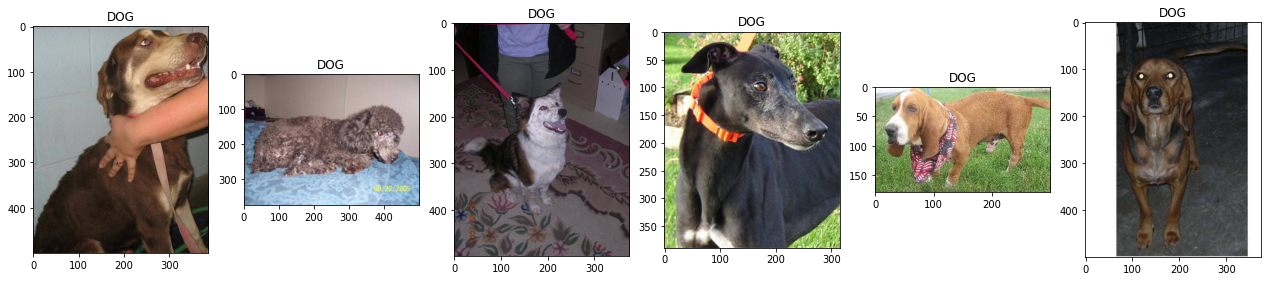

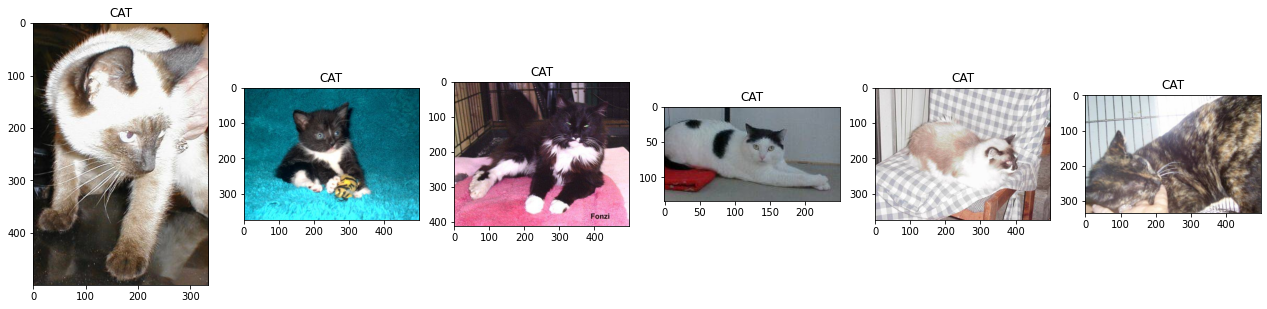

In [ ]:
# DOG와 CAT의 이미지 파일 절대 경로를 cv2.imread()로 읽어서 image array로 로드하고 이미지 시각화
# 이미지별로 서로 다른 이미지 사이즈를 가지고 있음. 
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 

def show_grid_images(image_path_list, ncols=8, augmentor=None, title=None):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
        axs[i].imshow(image)
        axs[i].set_title(title)  
        
dog_image_list = data_df[data_df['label']=='DOG']['path'].iloc[:6].tolist()
show_grid_images(dog_image_list, ncols=6, title='DOG')

cat_image_list = data_df[data_df['label']=='CAT']['path'].iloc[:6].tolist()
show_grid_images(cat_image_list, ncols=6, title='CAT')

In [ ]:
for image_path in dog_image_list:
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    print('image shape:', image.shape)
    
print('image height shape:', image[:, 0, 0].shape)
print('image width shape:', image[0, :, 0].shape)
print('image size:', image[:, :, 0].shape)

print('### image array:\n', image)

image shape: (500, 387, 3)
image shape: (375, 499, 3)
image shape: (499, 375, 3)
image shape: (389, 316, 3)
image shape: (180, 300, 3)
image shape: (500, 374, 3)
image height shape: (500,)
image width shape: (374,)
image size: (500, 374)
### image array:
 [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


### Preprocessing 과 Data Loading 메커니즘
* (초기) Keras는 Preprocessing과 Data Loading을 ImageDataGenerator 객체와 model의 fit_generator()가 상호 연결되어 수행. 
* model의 fit_generator()가 인자로 ImageDataGenerator가 생성한 generator 객체를 입력 받아서 image 파일부터 Model에 array/Tensor값 입력까지 Pipeline Stream으로 이어지게 구성. 
* generator 를 통해서 model에 Tensor로 공급하는 로직은 아래와 같음. 
* image 파일을 image array로 로드-> preprocessing 적용(augmentation -> array 값 scale 조정(0~1사이 값) -> array 크기 resize-> Normalization 적용)
* Label값 인코딩(문자열을 단일 숫자값/원-핫 인코딩) 또한 generator기반으로 손쉽게 변경해줌.
* 실제 Preprocessing과 Data Loading은 Model에서 fit_generator()를 호출하기 전까지는 수행되지 않음. 


### Preprocessing
* image file을 image array로 변환 시 0 ~ 1사이의 float형(float32)으로 변경. 
* image array size를 고정 크기로 재 조정.(예를 들어 224 x 224 )
* augmentation 적용.
* Normalization(평균과 표준 편차 재 조정)
* Label값은 binary classification 이냐 multiple classification에 따라 숫자형 값 Encoding. 
* multiple classification일 경우 Label Encoding을 One-hot encoding 할 지 결정. 

### Data Loading
* os에 있는 image 파일을 메모리로 array 형태로 로딩. 
* 이때 대량의 image 파일을 메모리로 loading 할 경우 메모리가 감당할 수 없으므로 일정 크기 단위로 array 변환. 즉 BATCH 크기 단위로 array 로딩. 

### ImageDataGenerator 객체 생성
* ImageDataGenerator 객체 생성시 인자로 augmentation과 rescale에 대한 인자값을 입력하여 Preprocessing 환경 설정. 

### ImageDataGenerator 객체의 flow_from_directory(), flow_from_dataframe() 호출
* 생성된 ImageDataGenerator 객체의 flow_from_directory() 메소드를 호출하여 Data Loading 환경 설정. 
* flow_from_directory()는 인자로 입력된 directory에 해당하는 디렉토리에 위치한 서브 디렉토리등에서 모든 image 파일을 검색. 
* 이때 바로 아래 서브 디렉토리의 이름을 Label로 인식하고, 해당 서브 디렉토리에 있는 이미지들을 해당 Label에 속하는 이미지 파일로 간주
* class_mode로 Label Encoding을 자동으로 수행. 
    * class_mode='categorical' 일 경우 문자열 Label을 원-핫 인코딩
    * class_mode='sparse' 일 경우 문자열 Label을 숫자값으로 인코딩
    * class_mode='binary' 일 경우 문자열 Label을 0/1 숫자값으로 인코딩
* batch_size로 한번에 읽어올 이미지 파일 갯수 설정(즉 Batch 크기 설정).
    * 모든 이미지 파일을 한번에 Numpy Array로 변환할 경우 메모리가 부족하게 되므로 수십개 단위로 이미지 파일을 한번에 읽어옴.
* target_size로 Model에 입력하기 위해서 원본 이미지의 크기를 변경할 resize 설정. 
* shuffle은 읽어온 데이터를 원래 순서대로가 아닌 섞어서 전달할지 여부
    

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Preprocessing과 Data Loading을 동시에 적용. 단 실제 Preprocessing과 Data Loading을 Model에서 fit_generator()를 호출하기 전까지는 동작하지 않음. 
# augmentation은 horizontal_flip(좌우 반전)만 적용하고 0 ~ 255의 pixel값을 0 ~ 1 로 scale만 적용. 
train_gen = ImageDataGenerator(horizontal_flip=True, rescale=1/255.)

# ImageDataGenerator 객체의 flow_from_directory() 메소드를 호출. 
# class_mode='categorical' 로 Label 데이터를 원-핫 인코딩, 이미지 array는 224 x 224 로 변경. Batch 크기는 64로 설정. 
train_flow_gen = train_gen.flow_from_directory(directory='/content/drive/MyDrive/Colab Notebooks/cat-and-dog/training_set/training_set' # image file이 있는 디렉토리 
                                                         ,target_size=(224, 224) # 원본 이미지를 최종 resize할 image size
                                                         ,class_mode='categorical' # 문자열 label을 자동으로 one-hot encoding 시켜줌. 
                                                         ,batch_size=64
                                                         )

Found 8005 images belonging to 2 classes.


### next()를 이용하여 flow_from_directory()로 반환된 Iterator 객체를 강제로 호출하여 어떤 값이 만들어 지는지 확인.  

In [ ]:
# next()를 flow_from_directory()로 반환된 Iterator 객체를 강제로 호출하여 어떤 값이 만들어 지는지 확인.  
# 튜플형태로 반환되고 튜플의 첫번째값은 image array, 두번째 값은 label array 임
# image array는 0~1 사이 값인 float32로 변환됨. label array는 2개 column으로 원-핫 인코딩 됨. 
# next(iter(train_flow_gen))
images_array, labels_array = next(train_flow_gen)
print(images_array.shape, labels_array.shape)
print(images_array[:1], labels_array[:1])

(64, 224, 224, 3) (64, 2)
[[[[0.87843144 0.62352943 0.16078432]
   [0.8980393  0.6431373  0.18039216]
   [0.89019614 0.63529414 0.16470589]
   ...
   [0.5803922  0.2784314  0.01176471]
   [0.5921569  0.2901961  0.02352941]
   [0.60784316 0.30588236 0.03921569]]

  [[0.9215687  0.6666667  0.20392159]
   [0.9333334  0.6784314  0.21568629]
   [0.9294118  0.6745098  0.21176472]
   ...
   [0.6156863  0.3137255  0.03921569]
   [0.63529414 0.33333334 0.05882353]
   [0.63529414 0.33333334 0.05882353]]

  [[0.86666673 0.6117647  0.15686275]
   [0.882353   0.627451   0.17254902]
   [0.91372555 0.65882355 0.20392159]
   ...
   [0.627451   0.3254902  0.04313726]
   [0.63529414 0.33333334 0.0509804 ]
   [0.6392157  0.3372549  0.05490196]]

  ...

  [[0.87843144 0.8588236  0.8470589 ]
   [0.8313726  0.8117648  0.8000001 ]
   [0.8352942  0.81568635 0.80392164]
   ...
   [0.9607844  0.9294118  0.8862746 ]
   [0.95294124 0.9215687  0.8705883 ]
   [0.9294118  0.8980393  0.8470589 ]]

  [[0.92549026 0.90

In [ ]:
# image array와 label array의 shape 확인. 
# batch_size만큼 한꺼번에 추출되므로 image array는 4차원, label array는 batch_size와 원-핫 인코딩을 감안하여 2차원 데이터
images_array = next(train_flow_gen)[0]
labels_array = next(train_flow_gen)[1]
print('##### image array shape:', images_array.shape)
print('#### label array shape:', labels_array.shape)

##### image array shape: (64, 224, 224, 3)
#### label array shape: (64, 2)


In [ ]:
# label array가 원-핫 인코딩 되어 있는지 확인.
labels_array

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.

### Model을 생성
* Input의 shape는 VGG, ResNet, Xception 모델이 원래 학습 이미지 사이즈로 가졌던 224 x 224 로 설정.   
* 이를 위해 flow_from_directory()로 원본 이미지를 224 x 224 로 변환함.  

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 128

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    # 개와 고양이 2 종류이므로 Dense의 units는 2
    output = Dense(2, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model


### optimizer, loss, metric 설정
* 위에서 flow_from_directory(class_mode='categorical') 로 설정했기에 label은 원핫 인코딩 되어 모델로 입력됨
* 따라서 loss는 categorical_crossentropy 를 적용해야 함. 

In [ ]:
# 위에서 flow_from_directory(class_mode='categorical') 로 설정했기에 label은 원핫 인코딩 되어 모델로 입력됨
# loss 는 원핫 인코딩을 기반으로 계산이 될 수 있는 loss 함수 필요. 여기서는 categorical_crossentropy를 써야함
# 만약 위에서 class_mode='sparse' 라면 loss는 sparse_categorical_crossentropy 여야 함.
model = create_model(model_name='xception', verbose=True)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 모델의 fit_generator()를 호출하여 학습 수행. 
* fit_generator()는 앞에서 생성한 iterator 객체를 인자로 받아서 image array, label array를 배치 크기 만큼 순차적으로 데이터로 가져와 학습 수행.   
* 입력 인자로 generator는 앞에서 생성한 image_data_generator를 입력
* epochs는 전체 학습 데이터를 가져와서 학습하는 횟수 의미
* steps_per_epoch는 전체 학습 데이터를 몇번 배치 작업으로 수행하는가를 의미. generator는 배치크기를 알수 있지만 전체 데이터에서 이를 batch 만큼 데이터를 몇번 가져와야 전체 데이터 학습을 수행할 지 알 수 없으므로 이를 설정해 줌. 전체 데이터 건수/배치 크기이며, 소수점 이하는 무조건 +1 로 절삭. 즉 전체 데이터 1001개 이고, 배치 크기가 10이면 steps_per_epochs는 101 임. 

In [ ]:
# train 데이터 건수는 generator의 samples 속성을 이용하여 가져올 수 있음. 
train_image_cnt = train_flow_gen.samples 
print(train_image_cnt)
# batch size는 64, 학습 데이터 image 개수는 8005 
model.fit_generator(train_flow_gen, epochs=15, 
                    steps_per_epoch=int(np.ceil(train_image_cnt/BATCH_SIZE))
                   )
                    
# 앞으론 fit()을 사용해야함. (fit_generator()와 같이 동작함)
# model.fit(train_flow_gen, epochs=15, steps_per_epoch=int(np.ceil(train_image_cnt/BATCH_SIZE)))

8005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
63/63 [==============================] - 416s 6s/step - loss: 0.1431 - accuracy: 0.9431
Epoch 2/15
63/63 [==============================] - 216s 3s/step - loss: 0.0769 - accuracy: 0.9722
Epoch 3/15
63/63 [==============================] - 116s 2s/step - loss: 0.1073 - accuracy: 0.9590
Epoch 4/15
63/63 [==============================] - 68s 1s/step - loss: 0.0925 - accuracy: 0.9668
Epoch 5/15
63/63 [==============================] - 56s 870ms/step - loss: 0.0574 - accuracy: 0.9816
Epoch 6/15
63/63 [==============================] - 48s 756ms/step - loss: 0.0541 - accuracy: 0.9819
Epoch 7/15
63/63 [==============================] - 47s 743ms/step - loss: 0.0393 - accuracy: 0.9874
Epoch 8/15
63/63 [==============================] - 47s 736ms/step - loss: 0.0277 - accuracy: 0.9889
Epoch 9/15
63/63 [==============================] - 47s 743ms/step - loss: 0.0275 - accuracy: 0.9903
Epoch 10/15
63/63 [==============================] - 47s 735ms/step - loss: 0.0328 - accuracy: 0.988

### Test 데이터로 성능 검증
* Test를 위한 데이터 Generator 생성. 

In [ ]:
# test data는 augmentation을 적용할 필요 없음. 
test_gen = ImageDataGenerator(rescale=1/255.)
test_flow_gen = test_gen.flow_from_directory(directory='/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set' # image file이 있는 디렉토리 
                                                         ,target_size=(IMAGE_SIZE, IMAGE_SIZE) # 원본 이미지를 최종 resize할 image size
                                                         ,class_mode='categorical' # 문자열 label을 자동으로 one-hot encoding 시켜줌. 
                                                         ,batch_size=BATCH_SIZE, shuffle=False
                                                         )

Found 2023 images belonging to 2 classes.


In [ ]:
# 모델의 evaluate_generator()를 호출하여 Test 데이터의 성능 측정.(evaluate()도 무방)
model.evaluate_generator(test_flow_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.08373112976551056, 0.9747899174690247]

### ImageDataGenerator 객체와 flow_from_dataframe()
* flow_from_dataframe()도 flow_from_directory()와 유사하게 메타 데이터 소스로 부터 이미지 파일과 label을 numpy array로 로드
* flow_from_dataframe()은 DataFrame 메타 데이터로 부터 로드함. 
* 일반적으로 flow_from_dataframe()이 데이터 조작등이 더 편하기 때문에 flow_from_directory() 보다 더 애용됨. 

### 이미지 파일의 절대경로 위치와 데이터세트 유형, label값을 가지는 메타 테이블용 DataFrame을 생성. 

In [ ]:
pd.set_option('display.max_colwidth', 200)

data_df = pd.DataFrame({'path':paths, 'dataset':dataset_gubuns, 'label':label_gubuns})
print(data_df['dataset'].value_counts())
data_df.head(10)

train    8005
test     2023
Name: dataset, dtype: int64


,path,dataset,label
0,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4115.jpg,test,DOG
1,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4043.jpg,test,DOG
2,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4098.jpg,test,DOG
3,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4120.jpg,test,DOG
4,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4073.jpg,test,DOG
5,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4041.jpg,test,DOG
6,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4060.jpg,test,DOG
7,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4106.jpg,test,DOG
8,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4108.jpg,test,DOG
9,/content/drive/MyDrive/Colab Notebooks/cat-and-dog/test_set/test_set/dogs/dog.4076.jpg,test,DOG


### 학습용/검증용/테스트용 DataFrame 을 생성

In [ ]:
data_df['dataset']=='train'

0        False
1        False
2        False
3        False
4        False
         ...  
10023     True
10024     True
10025     True
10026     True
10027     True
Name: dataset, Length: 10028, dtype: bool

In [ ]:
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']
print('train_df shape:', train_df.shape, 'test_df shape:', test_df.shape)

train_df shape: (8005, 3) test_df shape: (2023, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# scikit learn의 train_test_split()을 이용하여 train용, validation용 DataFrame을 생성
# stratify를 이용하여 label 값을 균등하게 분할 
tr_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=2021)
print('tr_df shape:', tr_df.shape, 'val_df shape:', val_df.shape)
print('tr_df label distribution:\n', tr_df['label'].value_counts())
print('val_df label distributuion:\n', val_df['label'].value_counts())

tr_df shape: (6804, 3) val_df shape: (1201, 3)
tr_df label distribution:
 DOG    3404
CAT    3400
Name: label, dtype: int64
val_df label distributuion:
 DOG    601
CAT    600
Name: label, dtype: int64


### 학습과 검증용 ImageDataGenerator 생성.
* flow_from_dataframe()은 인자로 dataframe = 메타 데이터용 DataFrame 입력 받음. 
* x_col은 메타 데이터용 DataFrame에서 image 파일의 절대경로 위치를 나타내는 column명을 의미
* y_col은 메타 데이터용 DataFrame에서 label값 column명을 의미. 이 때 y_col로 지정된 컬럼은 반드시 문자열(object type)이 되어야 함. 
* y_col의 경우 미리 encoding(label 또는 원핫)을 해서 숫자값으로 절대 변경하면 안됨.  
*  softmax가 아닌 sigmoid로 최종 출력하므로 class_mode='binary' 로 Label 데이터 변환, 이미지 array는 224 x 224 로 변경. Batch 크기는 64로 설정. 

In [ ]:
# IMAGE 크기와 BATCH 크기를 위한 환경 변수 설정. 
IMAGE_SIZE = 224
BATCH_SIZE = 64

### 학습용 ImageDataGenerator 생성과 Data generator 처리

In [ ]:


# 학습용과 검증용 ImageDataGenerator 생성. 학습용은 augmentation + rescale적용. 검증용은 rescale만 적용 
# augmentation은 horizontal_flip(좌우 반전)만 적용하고 0 ~ 255의 pixel값을 0 ~ 1 로 scale만 적용. 
tr_generator = ImageDataGenerator(horizontal_flip=True, rescale=1/255.)

# ImageDataGenerator 객체의 flow_from_dataframe()) 메소드를 호출. 
# flow_from_dataframe()은 인자로 dataframe = 메타 데이터용 DataFrame 입력 받음. 
# x_col은 메타 데이터용 DataFrame에서 image 파일의 절대경로 위치를 나타내는 column명을 의미
# y_col은 메타 데이터용 DataFrame에서 label값 column명을 의미. 이 때 y_col로 지정된 컬럼은 반드시 문자열(object type)이 되어야 함. 
# y_col의 경우 미리 encoding(label 또는 원핫)을 해서 숫자값으로 절대 변경하면 안됨.  
# softmax가 아닌 sigmoid로 최종 출력하므로 class_mode='binary' 로 Label 데이터 변환, 이미지 array는 224 x 224 로 변경. Batch 크기는 64로 설정. 
tr_flow_gen = tr_generator.flow_from_dataframe(dataframe=tr_df # image file이 있는 디렉토리
                                      ,x_col='path'
                                      ,y_col='label'
                                      ,target_size=(IMAGE_SIZE, IMAGE_SIZE) # 원본 이미지를 최종 resize할 image size
                                      ,class_mode='binary' # 문자열 label을 자동 Encoding. 
                                      ,batch_size=BATCH_SIZE
                                      ,shuffle=True
                                      )

Found 6804 validated image filenames belonging to 2 classes.


In [ ]:
images_array = next(tr_flow_gen)[0]
labels_array = next(tr_flow_gen)[1]
print('##### image array shape:', images_array.shape)
print('#### label array shape:', labels_array.shape)
print(images_array[0])
print(labels_array[0])

##### image array shape: (64, 224, 224, 3)
#### label array shape: (64,)
[[[0.18823531 0.18039216 0.18431373]
  [0.15686275 0.14901961 0.15294118]
  [0.15686275 0.15294118 0.14509805]
  ...
  [0.25490198 0.25882354 0.19607845]
  [0.28627452 0.2901961  0.227451  ]
  [0.2784314  0.28235295 0.21960786]]

 [[0.18431373 0.1764706  0.18039216]
  [0.15294118 0.14509805 0.14901961]
  [0.15294118 0.14901961 0.14117648]
  ...
  [0.2784314  0.28235295 0.21176472]
  [0.29803923 0.3019608  0.23137257]
  [0.29411766 0.29803923 0.227451  ]]

 [[0.18039216 0.17254902 0.1764706 ]
  [0.14901961 0.14117648 0.14509805]
  [0.14901961 0.14509805 0.13725491]
  ...
  [0.29411766 0.29803923 0.227451  ]
  [0.3019608  0.30588236 0.23529413]
  [0.3019608  0.30588236 0.23529413]]

 ...

 [[0.38823533 0.33333334 0.28235295]
  [0.38823533 0.33333334 0.28235295]
  [0.3529412  0.29803923 0.2627451 ]
  ...
  [0.3803922  0.654902   0.21568629]
  [0.37647063 0.6666667  0.28627452]
  [0.37647063 0.6313726  0.30980393]]

 

### 검증용 ImageDataGenerator 생성과 Data generator 처리

In [ ]:
# 검증용 ImageDataGenerator는 rescale만 적용. 
val_generator = ImageDataGenerator(rescale=1/255.)
val_flow_gen = val_generator.flow_from_dataframe(dataframe=val_df # image file이 있는 디렉토리
                                      ,x_col='path'
                                      ,y_col='label'
                                      ,target_size=(IMAGE_SIZE, IMAGE_SIZE) # 원본 이미지를 최종 resize할 image size
                                      ,class_mode='binary' # 문자열 label을 자동으로 one-hot encoding 시켜줌. 
                                      ,batch_size=BATCH_SIZE
                                      ,shuffle=False
                                      )

Found 1201 validated image filenames belonging to 2 classes.


### 모델 생성

In [ ]:
def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    # 최종 output 출력을 softmax에서 sigmoid로 변환. 
    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [ ]:
model = create_model(model_name='xception')
# 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

### fit() 또는 fit_generator() 호출하여 학습 수행.
* validation_data에는 앞에서 검증용으로 생성한 val_generator를 입력
* validation_steps는 검증용 데이터에 대한 steps_per_epoch임. 

In [ ]:
# 학습과 검증용 steps_per_epoch 계산 
N_EPOCHS = 15

model.fit(tr_flow_gen, epochs=N_EPOCHS,
          steps_per_epoch=int(np.ceil(tr_df.shape[0]/BATCH_SIZE)),
          validation_data=val_flow_gen, 
          validation_steps=int(np.ceil(val_df.shape[0]/BATCH_SIZE)), 
          callbacks=[rlr_cb, ely_cb])

Epoch 1/15
107/107 [==============================] - 91s 807ms/step - loss: 0.1170 - accuracy: 0.9516 - val_loss: 3.8455 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 85s 789ms/step - loss: 0.0821 - accuracy: 0.9697 - val_loss: 0.1751 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 85s 789ms/step - loss: 0.0576 - accuracy: 0.9780 - val_loss: 0.3543 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - 85s 789ms/step - loss: 0.0551 - accuracy: 0.9827 - val_loss: 0.6372 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 85s 790ms/step - loss: 0.0345 - accuracy: 0.9868 - val_loss: 0.0938 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 6/15
107/107 [==============================] - 85s 790ms/step - loss: 0.0231 - accuracy: 0.9927 - val_loss: 0.0736 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/15
107/107 [==============================] 

### 테스트용 ImageDataGenerator 생성과 Data generator 처리 후 Evaluation 수행

In [ ]:
# test data는 augmentation을 적용할 필요 없음. 
test_generator = ImageDataGenerator(rescale=1/255.)
test_flow_gen = test_generator.flow_from_dataframe(dataframe=test_df # image file이 있는 디렉토리
                                      ,x_col='path'
                                      ,y_col='label'
                                      ,target_size=(IMAGE_SIZE, IMAGE_SIZE) # 원본 이미지를 최종 resize할 image size
                                      ,class_mode='binary' # 문자열 label을 자동으로 encoding. 
                                      ,batch_size=BATCH_SIZE
                                      ,shuffle=False
                                      )
# evaluation으로 성능 검증
model.evaluate(test_flow_gen)


Found 2023 validated image filenames belonging to 2 classes.
32/32 [==============================] - 9s 290ms/step - loss: 0.0865 - accuracy: 0.9807


[0.08652454614639282, 0.9807217121124268]

### image data의 scaling preprocessing 유형
* 0 ~ 1 사이, -1 ~ 1 사이, z-score 변환 중에 선택. 
* pretrained 모델은 주로 tf와 torch 프레임웍으로 생성 
* tf는 -1 ~ 1 택. torch는 전통적으로 z-score 변환(0 ~ 1로 scaling 후 ImageNet 데이터 세트의 이미지 채널별 평균값, 표준편차값을 이용하여 z score 변환 적용)

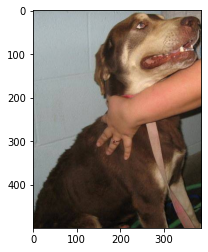

In [ ]:
import cv2

# 임의의 이미지 한개 선택. 
image = cv2.cvtColor(cv2.imread(data_df['path'].iloc[0]), cv2.COLOR_BGR2RGB)
plt.imshow(image)

### tf 또는 torch 유형으로 변경하는 함수 생성. 

In [ ]:
def preprocessing_scaling(x, mode='tf'):
    if mode == 'tf':
        x = x/127.5
        x -= 1.
    
    elif mode == 'torch':
        x = x/255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        x[:, :, 0] = (x[:, :, 0] - mean[0])/std[0]
        x[:, :, 1] = (x[:, :, 1] - mean[1])/std[1]
        x[:, :, 2] = (x[:, :, 2] - mean[2])/std[2]
        
    return x

scaled_image_tf = preprocessing_scaling(image, mode='tf')
scaled_image_torch = preprocessing_scaling(image, mode='torch')

### scale 된 이미지 pixel값의 histogram 시각화 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


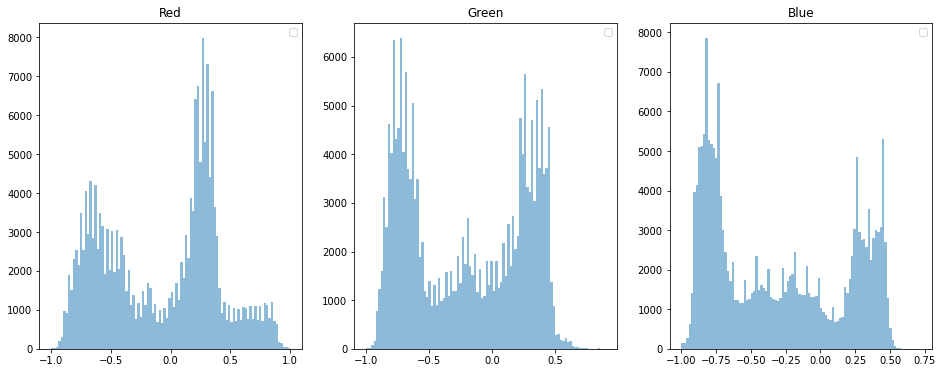

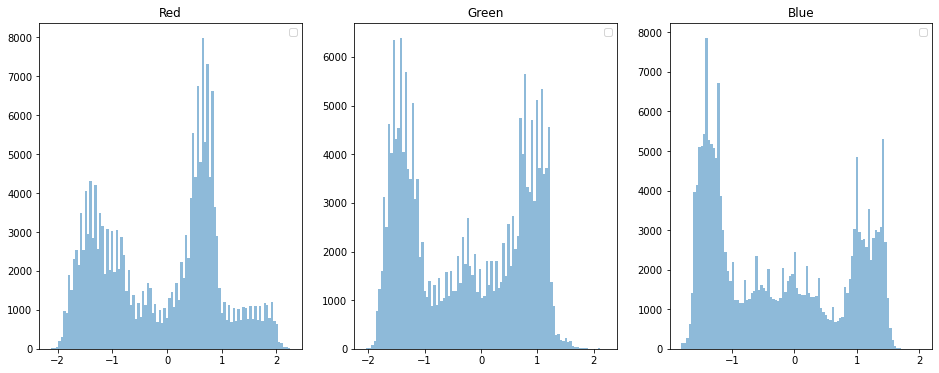

In [ ]:
def show_pixel_histogram(image):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

    for i in range(3):
        # i값 0 일때 Red 채널, i값 1일때 Green Channel, i값 2일때 Blue Channel Histogram 표현 
        axs[i].hist(image[:, :, i].flatten(), bins=100, alpha=0.5)
        axs[i].legend(loc='upper right')
        if i==0:
            title_str = 'Red'
        elif i==1:
            title_str = 'Green'
        else: 
            title_str = 'Blue'
        axs[i].set(title=title_str)
        
show_pixel_histogram(scaled_image_tf)
show_pixel_histogram(scaled_image_torch)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


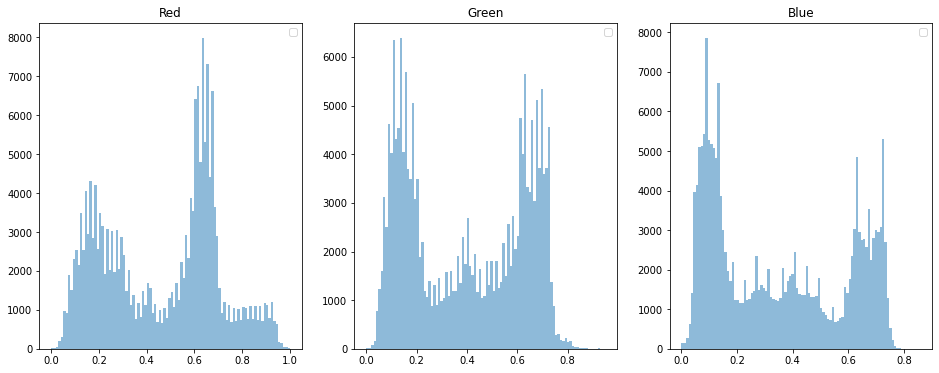

In [ ]:
show_pixel_histogram(image/255.0)

### 개별 pretrained 모델들은 고유한 scaling 방식을 적용

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


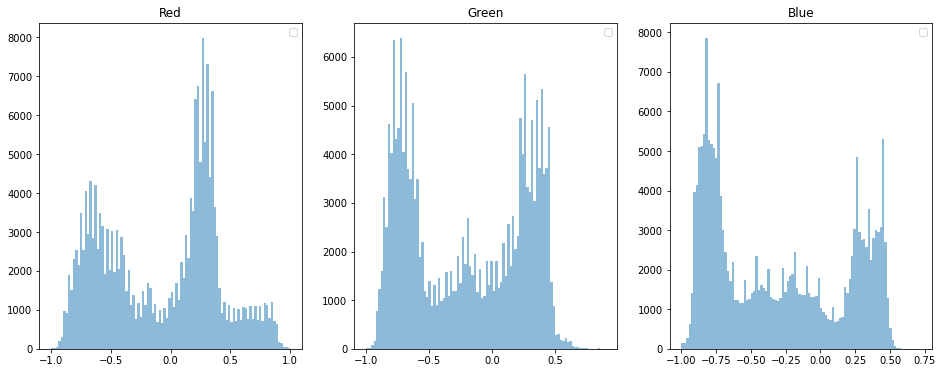

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

# Xception의 scaling 방식은 tf
scaled_image_xception = preprocess_input(image)
show_pixel_histogram(scaled_image_xception)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


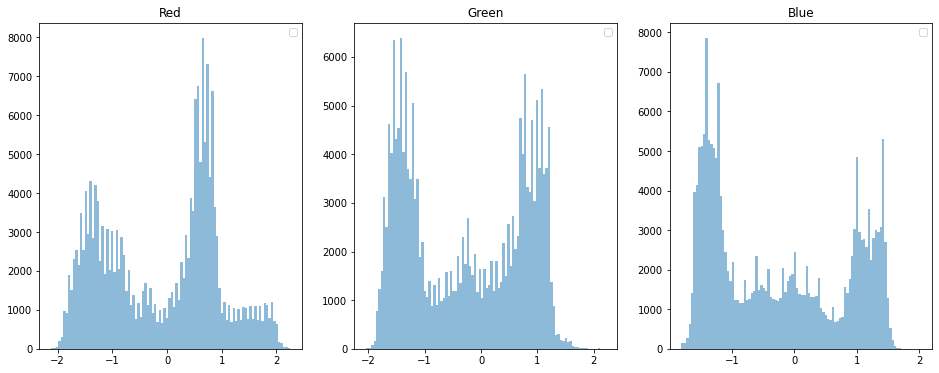

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input

# DenseNet의 scaling 방식은 torch
scaled_image_densenet = preprocess_input(image)
show_pixel_histogram(scaled_image_densenet)

### ImageDataGenerator에 preprocess_input()을 적용시 preprocessing_function 파라미터를 사용 

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

#tr_generator = ImageDataGenerator(horizontal_flip=True, rescale=1/255.)
tr_generator = ImageDataGenerator(horizontal_flip=True, preprocessing_function=preprocess_input)
tr_flow_gen = tr_generator.flow_from_dataframe(dataframe=tr_df # image file이 있는 디렉토리
                                      ,x_col='path'
                                      ,y_col='label'
                                      ,target_size=(IMAGE_SIZE, IMAGE_SIZE) # 원본 이미지를 최종 resize할 image size
                                      ,class_mode='binary' # 문자열 label을 자동 Encoding. 
                                      ,batch_size=BATCH_SIZE
                                      ,shuffle=True
                                      )

Found 6804 validated image filenames belonging to 2 classes.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


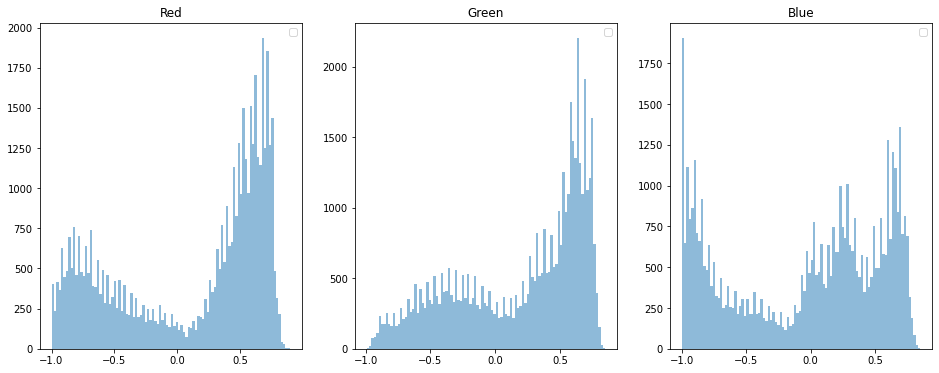

In [ ]:
images_array = next(tr_flow_gen)[0]
labels_array = next(tr_flow_gen)[1]

show_pixel_histogram(images_array[0])